# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [5]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2019-03-31 18:24:45--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  11.1MB/s    in 18s     

2019-03-31 18:25:03 (9.91 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2019-03-31 18:25:03--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  10.5MB/s    in 6.4s    

2019-03-31 18:25:09 (9.57 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2019-03-31 18:25:09--
Total wall clock time: 25s
Downloaded: 2 files, 235M in

In [0]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [0]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [0]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10)
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [13]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        if scheduler:
            scheduler.step()

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    accs = []
    for data, target in loader:
        data_gpu = data.to(device)
        output = model(data_gpu)
        pred = torch.argmax(output, dim=1)
        accs.append(np.sum(target.numpy() == pred.cpu().numpy()) / target.shape[0])
    return np.mean(accs)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.682376, Train accuracy: 0.791574, Val accuracy: 0.813175
Average loss: 0.581291, Train accuracy: 0.825462, Val accuracy: 0.827049
Average loss: 0.530544, Train accuracy: 0.840767, Val accuracy: 0.801059
Average loss: 0.498244, Train accuracy: 0.851926, Val accuracy: 0.847991
Average loss: 0.472080, Train accuracy: 0.859008, Val accuracy: 0.852636


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [0]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

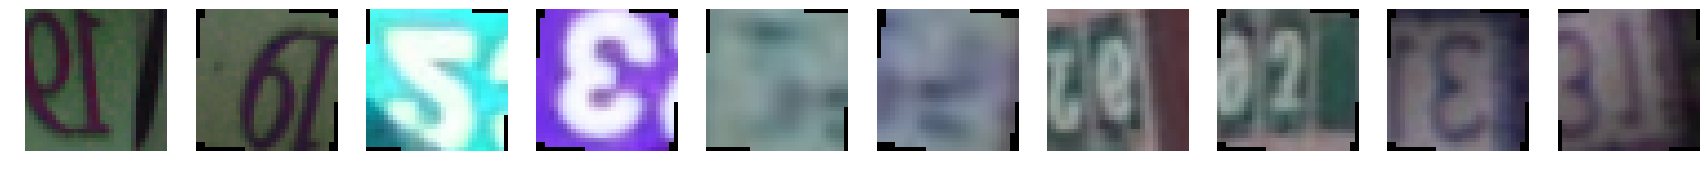

In [15]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [0]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47], std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

In [17]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.596288, Train accuracy: 0.821230, Val accuracy: 0.826186
Average loss: 0.531303, Train accuracy: 0.840614, Val accuracy: 0.814512
Average loss: 0.515194, Train accuracy: 0.844077, Val accuracy: 0.835931
Average loss: 0.503695, Train accuracy: 0.848019, Val accuracy: 0.852818
Average loss: 0.488540, Train accuracy: 0.852438, Val accuracy: 0.860301


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [0]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.Tanh(),
    nn.MaxPool2d(2, 2),    
    Flattener(),
    nn.Linear(400, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [19]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Average loss: 2.251863, Train accuracy: 0.203887, Val accuracy: 0.301886
Average loss: 2.100450, Train accuracy: 0.353889, Val accuracy: 0.439185
Average loss: 1.973092, Train accuracy: 0.495649, Val accuracy: 0.576725
Average loss: 1.846805, Train accuracy: 0.631522, Val accuracy: 0.713716
Average loss: 1.729433, Train accuracy: 0.751868, Val accuracy: 0.785889
Average loss: 1.693598, Train accuracy: 0.778521, Val accuracy: 0.783080
Average loss: 1.680580, Train accuracy: 0.788742, Val accuracy: 0.796049
Average loss: 1.672866, Train accuracy: 0.795294, Val accuracy: 0.806563
Average loss: 1.666511, Train accuracy: 0.801403, Val accuracy: 0.809286
Average loss: 1.662220, Train accuracy: 0.804628, Val accuracy: 0.814421


# Подбор гиперпараметров

In [57]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])


def create_lenet(learning_rate, l2_reg, anneal_epoch, anneal_coeff):
    lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.Tanh(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(6, 16, 5),
        nn.Tanh(),
        nn.MaxPool2d(2, 2),    
        Flattener(),
        nn.Linear(400, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)
    return lenet_model, optimizer, scheduler


batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {}

learning_rates = [1e-2, 1e-3]

for learning_rate in learning_rates:
    anneal_epoch = 20
    l2_reg = 1e-4
    lenet_model, optimizer, scheduler = create_lenet(learning_rate, l2_reg, anneal_epoch, anneal_coeff)
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)
    params = Hyperparams(learning_rate=learning_rate, anneal_epochs=anneal_epoch, reg=l2_reg)
    result = RunResult(
        model=lenet_model,
        train_history=train_history,
        val_history=val_history,
        final_val_accuracy=val_history[-1]
    )
    run_record[params] = result
    print('{} passed'.format(params))
    
learning_rates = [1, 1e-1]
anneal_coeff = 0.2
anneal_epochs = [1, 2, 3, 5, 10]

for learning_rate in learning_rates:
    for anneal_epoch in reversed(anneal_epochs):
        l2_reg = 1e-3
        lenet_model, optimizer, scheduler = create_lenet(learning_rate, l2_reg, anneal_epoch, anneal_coeff)
        loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)
        params = Hyperparams(learning_rate=learning_rate, anneal_epochs=anneal_epoch, reg=l2_reg)
        result = RunResult(
            model=lenet_model,
            train_history=train_history,
            val_history=val_history,
            final_val_accuracy=val_history[-1]
        )
        run_record[params] = result
        print('{} passed'.format(params))

Average loss: 2.245105, Train accuracy: 0.183599, Val accuracy: 0.189195
Average loss: 2.148274, Train accuracy: 0.240402, Val accuracy: 0.332243
Average loss: 1.648412, Train accuracy: 0.444562, Val accuracy: 0.577167
Average loss: 1.054976, Train accuracy: 0.675528, Val accuracy: 0.762349
Average loss: 0.779012, Train accuracy: 0.773044, Val accuracy: 0.809980
Average loss: 0.662054, Train accuracy: 0.805174, Val accuracy: 0.831808
Average loss: 0.598659, Train accuracy: 0.822476, Val accuracy: 0.842868
Average loss: 0.558372, Train accuracy: 0.833908, Val accuracy: 0.851948
Average loss: 0.530987, Train accuracy: 0.841757, Val accuracy: 0.854621
Average loss: 0.508277, Train accuracy: 0.849213, Val accuracy: 0.858442
Hyperparams(learning_rate=0.01, anneal_epochs=20, reg=0.0001) passed
Average loss: 2.294016, Train accuracy: 0.127154, Val accuracy: 0.167293
Average loss: 2.273098, Train accuracy: 0.181005, Val accuracy: 0.188439
Average loss: 2.258126, Train accuracy: 0.189281, Val a

In [58]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=5, reg=0.001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [55]:
best_model = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.MaxPool2d(2, 2),
    Flattener(),
    nn.Linear(1600, 400),
    nn.BatchNorm1d(400),
    nn.LeakyReLU(),
    nn.Linear(400, 100),
    nn.BatchNorm1d(100),
    nn.LeakyReLU(),
    nn.Linear(100, 10)
)
best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(best_model.parameters(), lr=1, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=3)
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer,
                                                       epoch_num, scheduler)

Average loss: 0.702439, Train accuracy: 0.773283, Val accuracy: 0.853790
Average loss: 0.424967, Train accuracy: 0.867488, Val accuracy: 0.882545
Average loss: 0.367442, Train accuracy: 0.886684, Val accuracy: 0.891949
Average loss: 0.329114, Train accuracy: 0.899584, Val accuracy: 0.894678
Average loss: 0.226487, Train accuracy: 0.930860, Val accuracy: 0.926281
Average loss: 0.199083, Train accuracy: 0.940655, Val accuracy: 0.928141
Average loss: 0.183859, Train accuracy: 0.944869, Val accuracy: 0.926730
Average loss: 0.155931, Train accuracy: 0.953486, Val accuracy: 0.928658
Average loss: 0.141546, Train accuracy: 0.957496, Val accuracy: 0.929215
Average loss: 0.136105, Train accuracy: 0.959100, Val accuracy: 0.930665


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [59]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_run.model, test_loader)
print("LeNet test accuracy: %2.4f" % test_accuracy)

LeNet test accuracy: 0.8904


In [56]:
test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy: %2.4f" % test_accuracy)

Final test accuracy: 0.9253
